In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from ydata_profiling import ProfileReport

In [113]:
# 한글
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 깨짐 처리
plt.rcParams['axes.unicode_minus'] = False
# 숫자
pd.options.display.float_format = "{:.2f}".format

In [114]:
# 데이터 로드(학습데이터)
df = pd.read_csv('dataset/whr_200522.csv', encoding="CP949")
df = df.sort_values(by=['CountryName','Year'])
df.head()

# 1.기본 정보
# Year: 조사 연도
# CountryName: 국가명
# LadderScore: 행복 점수 (0~10점)

# 3. 행복 요인 (행복 점수 기여 요소)
# Economy: 경제 수준 (1인당 GDP)
# SocialSupport: 사회적 지원 (타인과의 유대 및 지원 수준)
# HealthyLife: 기대 건강 수명
# Freedom: 삶의 선택 자유도
# Generosity: 관대함 (기부 및 타인 배려 수준)
# Corruption: 부패 인식 (낮을수록 신뢰 높음)

,CountryName,Year,LadderScore,Economy,SocialSupport,HealthyLife,Freedom,Generosity,Corruption
0,Afghanistan,2008,3.72,7.35,0.45,50.50,0.72,0.17,0.88
1,Afghanistan,2009,4.40,7.51,0.55,50.80,0.68,0.19,0.85
2,Afghanistan,2010,4.76,7.61,0.54,51.10,0.60,0.12,0.71
3,Afghanistan,2011,3.83,7.58,0.52,51.40,0.50,0.16,0.73
4,Afghanistan,2012,3.78,7.66,0.52,51.70,0.53,0.24,0.78


In [115]:
print(df.shape)

(2199, 9)


In [116]:
# 결측치 처리
# 1.Null값 찾기
print(df.isnull().sum())

CountryName        0
Year               0
LadderScore        0
Economy           20
SocialSupport     13
HealthyLife       54
Freedom           33
Generosity        73
Corruption       116
dtype: int64


In [117]:
# 전처리(결측치 값 평균값으로 대체)
df['Economy'] = df['Economy'].fillna(df['Economy'].mean())
df['HealthyLife'] = df['HealthyLife'].fillna(df['HealthyLife'].mean())
df['SocialSupport'] = df['SocialSupport'].fillna(df['SocialSupport'].mean())
df['Freedom'] = df['Freedom'].fillna(df['Freedom'].mean())
df['Generosity'] = df['Generosity'].fillna(df['Generosity'].mean())
df['Corruption'] = df['Corruption'].fillna(df['Corruption'].mean())

In [118]:
# 2.Null값 확인
print(df.isnull().sum())

CountryName      0
Year             0
LadderScore      0
Economy          0
SocialSupport    0
HealthyLife      0
Freedom          0
Generosity       0
Corruption       0
dtype: int64


In [119]:
# 나라 컬럼 Drop
#df = df.drop(['CountryName'],axis=1)
print(df.shape)

(2199, 9)


      Year  LadderScore  Economy  SocialSupport  HealthyLife  Freedom  \
0     2008         3.72     7.35           0.45        50.50     0.72   
1     2009         4.40     7.51           0.55        50.80     0.68   
2     2010         4.76     7.61           0.54        51.10     0.60   
3     2011         3.83     7.58           0.52        51.40     0.50   
4     2012         3.78     7.66           0.52        51.70     0.53   
...    ...          ...      ...            ...          ...      ...   
2194  2018         3.62     7.78           0.78        52.62     0.76   
2195  2019         2.69     7.70           0.76        53.10     0.63   
2196  2020         3.16     7.60           0.72        53.58     0.64   
2197  2021         3.15     7.66           0.69        54.05     0.67   
2198  2022         3.30     7.67           0.67        54.52     0.65   

      Generosity  
0           0.17  
1           0.19  
2           0.12  
3           0.16  
4           0.24  
...      

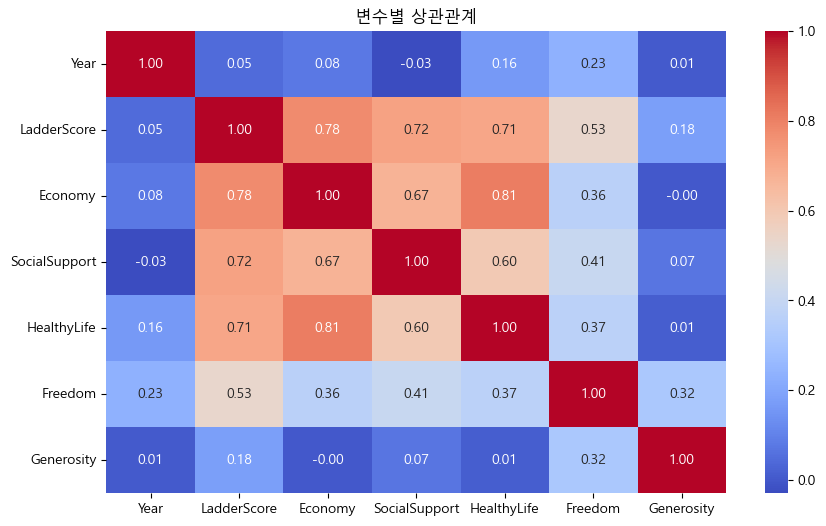

In [120]:
# 변수별 상관관계
feature_df = df.iloc[:,1:8]
print(feature_df)
plt.figure(figsize=(10,6))
sns.heatmap(feature_df.corr(),annot=True, cmap='coolwarm', fmt='.2f')
plt.title("변수별 상관관계")
plt.show()

In [121]:
print(feature_df.shape)
feature_df.head()

(2199, 7)


,Year,LadderScore,Economy,SocialSupport,HealthyLife,Freedom,Generosity
0,2008,3.72,7.35,0.45,50.50,0.72,0.17
1,2009,4.40,7.51,0.55,50.80,0.68,0.19
2,2010,4.76,7.61,0.54,51.10,0.60,0.12
3,2011,3.83,7.58,0.52,51.40,0.50,0.16
4,2012,3.78,7.66,0.52,51.70,0.53,0.24


In [122]:
# 데이터 컬럼 확인
print("Train Columns:",feature_df.columns.tolist())

Train Columns: ['Year', 'LadderScore', 'Economy', 'SocialSupport', 'HealthyLife', 'Freedom', 'Generosity']


In [123]:
# 필요 없는 열 제거 (예시)
df = df[['Year', 'CountryName', 'LadderScore', 'Economy', 'SocialSupport', 'HealthyLife', 'Freedom']]

# MinMax Scaling (0~1 정규화)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['LadderScore', 'Economy', 'SocialSupport', 'HealthyLife', 'Freedom']])

# 스케일링된 데이터를 다시 데이터프레임으로 변환
feature_df = pd.DataFrame(scaled_features, columns=['LadderScore', 'Economy', 'SocialSupport', 'HealthyLife', 'Freedom'])
feature_df['Year'] = df['Year']
feature_df['CountryName'] = df['CountryName']

feature_df.head()

,LadderScore,Economy,SocialSupport,HealthyLife,Freedom,Year,CountryName
0,0.36,0.30,0.29,0.65,0.63,2008,Afghanistan
1,0.46,0.32,0.43,0.65,0.58,2009,Afghanistan
2,0.52,0.34,0.41,0.66,0.47,2010,Afghanistan
3,0.38,0.33,0.39,0.66,0.33,2011,Afghanistan
4,0.37,0.35,0.39,0.66,0.38,2012,Afghanistan


In [ ]:
# GRU 입력을 위한 reshape (samples, time steps, features)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])  # LadderScore 값만 예측
    return np.array(X), np.array(y)

seq_length = 5  # 5년치 데이터를 사용하여 다음 해 행복도 예측

country_data = feature_df.drop(['Year','CountryName'], axis=1).values

X, y = create_sequences(country_data, seq_length)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print("X_train:", X_val)  # (샘플 수, 5년, 특성 수)
print("X_train shape:", X_train.shape)  # (샘플 수, 5년, 특성 수)
print("y_train shape:", y_train.shape)  # (샘플 수,)
#print("y_train shape:", y_scaled.shape)  # (샘플 수,)

X_train: [[[0.55060849 0.62942161 0.85902503 0.83498756 0.67125172]
  [0.50103888 0.62942161 0.79183136 0.83498756 0.77303989]
  [0.54170377 0.62942161 0.73781291 0.83498756 0.82530949]
  [0.56040368 0.62942161 0.73517787 0.83498756 0.68775791]
  [0.5644108  0.64005214 0.90250329 0.57973581 0.53782669]]

 [[0.50103888 0.62942161 0.79183136 0.83498756 0.77303989]
  [0.54170377 0.62942161 0.73781291 0.83498756 0.82530949]
  [0.56040368 0.62942161 0.73517787 0.83498756 0.68775791]
  [0.5644108  0.64005214 0.90250329 0.57973581 0.53782669]
  [0.58222024 0.64689588 0.73781291 0.59301897 0.59422283]]

 [[0.54170377 0.62942161 0.73781291 0.83498756 0.82530949]
  [0.56040368 0.62942161 0.73517787 0.83498756 0.68775791]
  [0.5644108  0.64005214 0.90250329 0.57973581 0.53782669]
  [0.58222024 0.64689588 0.73781291 0.59301897 0.59422283]
  [0.60329475 0.65031774 0.76679842 0.60630212 0.67537827]]

 ...

 [[0.35945384 0.36174026 0.66930171 0.65648292 0.56258597]
  [0.36420303 0.35978491 0.71146245

In [125]:
# GRU 모델 생성
tanh_model = Sequential([
    GRU(64,return_sequences=True,input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1, activation='tanh')
])

c:\pythonEdu\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [126]:
# GRU 모델 생성
relu_model = Sequential([
    GRU(32,return_sequences=True,input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1, activation='relu')
])

In [127]:
linear_model = Sequential([
    GRU(32,return_sequences=True,input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1, activation='linear')
])

In [128]:
tanh_model.compile(optimizer='adam', loss='mean_squared_error')
relu_model.compile(optimizer='adam', loss='mean_squared_error')
linear_model.compile(optimizer='adam', loss='mean_squared_error')

In [129]:
# Early Stopping - verbose=1로 설정하여 진행상황 확인
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,    # 10번의 에폭 동안 개선이 없으면 학습 중단
    restore_best_weights=True,    #  가장 좋은 성능을 보였던 모델의 가중치(weights)를 복원
    verbose=1       # 중단 시 메시지 출력
)

In [130]:
# 모델 학습
tanh_history = tanh_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_val, y_val), callbacks= [early_stop])
relu_history = relu_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_val, y_val), callbacks= [early_stop])
linear_history = linear_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_val, y_val), callbacks= [early_stop])

Epoch 1/100


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0401 - val_loss: 0.0176
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0174 - val_loss: 0.0139
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0150 - val_loss: 0.0128
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - val_loss: 0.0114
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - val_loss: 0.0105
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 - val_loss: 0.0094
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - val_loss: 0.0120
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - val_loss: 0.0087
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110 - val_loss: 0.0088
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101 - val_l

In [131]:
# 학습이 몇 번째 에폭에서 멈췄는지 확인
actual_epochs = len(tanh_history.history['loss'])
print("학습완료", actual_epochs, "번째")
actual_epochs2 = len(relu_history.history['loss'])
print("학습완료", actual_epochs2, "번째")
actual_epochs3 = len(linear_history.history['loss'])
print("학습완료", actual_epochs3, "번째")

학습완료 63 번째
학습완료 50 번째
학습완료 50 번째


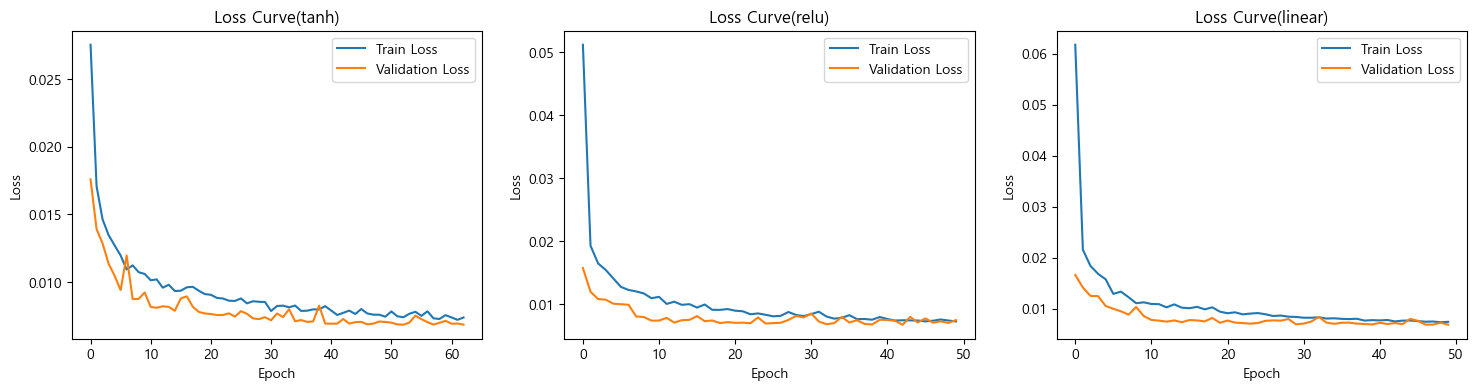

In [132]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.plot(tanh_history.history['loss'], label='Train Loss')
plt.plot(tanh_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve(tanh)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(relu_history.history['loss'], label='Train Loss')
plt.plot(relu_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve(relu)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(linear_history.history['loss'], label='Train Loss')
plt.plot(linear_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve(linear)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

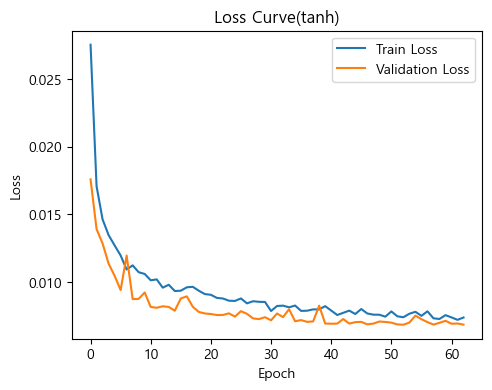

In [133]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.plot(tanh_history.history['loss'], label='Train Loss')
plt.plot(tanh_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve(tanh)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [134]:
# 예측 및 평가(tanh 활성화 함수 모델 선택)
y_pred = tanh_model.predict(X_val, verbose=0)
# LadderScore만 따로 스케일링
ladder_scaler = MinMaxScaler()
ladder_scaler.fit_transform(df[['LadderScore']])      # 원래 행복 점수 데이터로 스케일러 학습
# 역정규화
y_val_invers = ladder_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_pred_invers = ladder_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

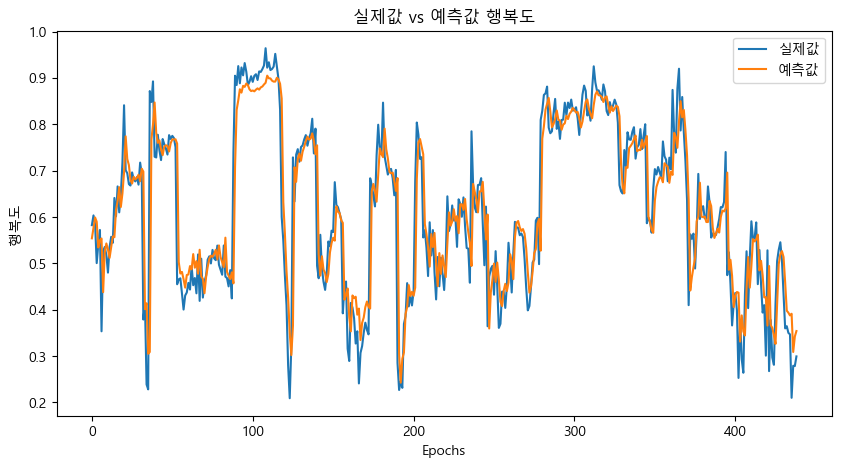

In [135]:
# 실제값 vs 예측값 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_val, label="실제값")
plt.plot(y_pred, label="예측값")
plt.xlabel("Epochs")
plt.ylabel("행복도")
plt.legend()
plt.title("실제값 vs 예측값 행복도")
plt.show()

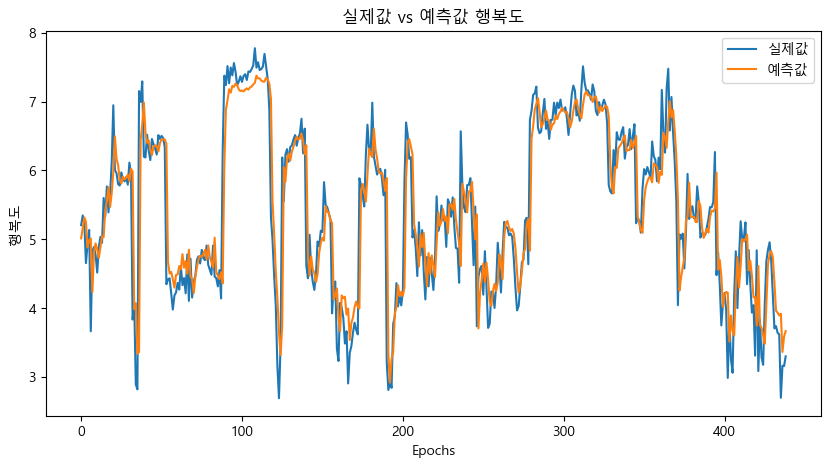

In [136]:
# 실제값 vs 예측값 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_val_invers, label="실제값")
plt.plot(y_pred_invers, label="예측값")
plt.xlabel("Epochs")
plt.ylabel("행복도")
plt.legend()
plt.title("실제값 vs 예측값 행복도")
plt.show()

In [138]:
#  모델 저장 (선택 사항)
tanh_model.save('model/whr_gru_model.h5')
print("모델 저장 완료!")

모델 저장 완료!
